# Classification of TL2LA: Pattern-based Contribution Method

<br> ------------------------------------------------------------------------
<br> Apply the Pattern-based Contribution Method to the 
<br> transformed Lyft level 5 dataset
<br>
<br> tl2la
<br> Copyright (c) 2023 Andreas Weber. All Rights Reserved.
<br> ------------------------------------------------------------------------

In [1]:
import pandas as pd
from src.assignment.assignmet_pattern import apply_frame_contribution,generalize_over_scenes_by_class_majority, heuristic_data_preprocessing
from src.assignment.evaluation import visualize_confusion_matrix, visualize_metrics
from src.common.definitions import DATASET_TYPE
from src.common.helper import init_dataset
from src.dataset_operations.extended_map_api import ExtendedMapAPI
from src.dataset_operations.junction_dataset import JunctionDataset

##  Initialization of required Objects

In [2]:
dataset_type = "trainfull"
cfg, dm, zarr_dataset = init_dataset(config_name=dataset_type)
mapAPI = ExtendedMapAPI.from_config(dm, cfg)
junctionDataset = JunctionDataset(cfg, mapAPI, zarr_dataset)

##  Initialization of required Datasets

In [3]:
# Junction, Branch and Lane Definitions
extended_branch_df = junctionDataset.get_branch_dataset(DATASET_TYPE.EXTENDED)

# Derived Traffic Light States for a whole scene
tl_state_scene_df = junctionDataset.get_scene_tl_state()

gt = junctionDataset.get_ground_truth_corrected()
print("Number of semantic labels corrected: ", gt["corrected"].sum())

Number of semantic labels corrected:  20


## Apply Pattern-based Contribution on Dataset

In [19]:
only_ego = True

# adjust this if you dont want to use all scenes for analysis (1000 scenes = all scenes)
if only_ego: datasets_to_load = 1000
else: datasets_to_load = 1000

In [6]:
res = []
for i in range(datasets_to_load):
    current_combined_features = junctionDataset.get_combined_features(i)
    current_combined_features = heuristic_data_preprocessing(current_combined_features, mapAPI, tl_state_scene_df, extended_branch_df, only_ego=only_ego)
    res.append(current_combined_features)
    del current_combined_features
combined_features_dfs = pd.concat(res)
combined_features_dfs

,scene_idx,frame_idx,agent_id,lane_id,junction_id,branch_id,sequence_head_lane_id,v,a,density,...,x,y,state_known_start_frame,state_known_end_frame,state_change_frame,interpreted_state,Unnamed: 0,lane_sequence_id,num_sequence_head_lane_ids,turn_type
0,1,161,0,6AUT,y4Ss,Evy5c,+xmM,9.534377,-1.061951,1,...,738.140930,-1399.188354,126,248,-1,0,340.0,110.0,1.0,0
1,1,161,0,6AUT,y4Ss,Evy5c,+xmM,9.534377,-1.061951,1,...,738.140930,-1399.188354,93,248,-1,0,340.0,110.0,1.0,0
2,1,162,0,6AUT,y4Ss,Evy5c,+xmM,9.588541,0.541639,1,...,737.334106,-1398.670288,126,248,-1,0,340.0,110.0,1.0,0
3,1,162,0,6AUT,y4Ss,Evy5c,+xmM,9.588541,0.541639,1,...,737.334106,-1398.670288,93,248,-1,0,340.0,110.0,1.0,0
4,1,163,0,6AUT,y4Ss,Evy5c,+xmM,9.552310,-0.362309,1,...,736.528625,-1398.156860,126,248,-1,0,340.0,110.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113564,13368,86,6,aVLS,ctKJ,E6WDG,aVLS,12.753825,-0.231876,1,...,-719.932617,1133.091309,0,86,-1,1,55.0,19.0,1.0,1
113565,13368,86,6,aVLS,ctKJ,E6WDG,aVLS,12.753825,-0.231876,1,...,-719.932617,1133.091309,18,86,25,2,55.0,19.0,1.0,1
113566,13368,86,739,cULS,ctKJ,E6WDG,cULS,17.251764,-0.599461,2,...,-712.174622,1114.635376,0,86,-1,1,66.0,21.0,1.0,0
113567,13368,86,739,cULS,ctKJ,E6WDG,cULS,17.251764,-0.599461,2,...,-712.174622,1114.635376,0,86,-1,1,66.0,21.0,1.0,0


In [7]:
combined_features = combined_features_dfs
print("Dataset size:", combined_features.shape)

Dataset size: (9059395, 26)


### Dataset Statistics

In [8]:
num_scenes = combined_features["scene_idx"].nunique()
print("Number of scenes considered: ", num_scenes)
num_agents = combined_features.groupby(by=["scene_idx", "agent_id"]).ngroups
print("Number of agents considered: ", num_agents)

Number of scenes considered:  9356
Number of agents considered:  108915


### Calculate contribution for dataset

In [9]:
combined_features_contributed = apply_frame_contribution(combined_features)
combined_features_contributed.head()

,scene_idx,frame_idx,agent_id,lane_id,junction_id,branch_id,sequence_head_lane_id,v,a,density,...,y,state_known_start_frame,state_known_end_frame,state_change_frame,interpreted_state,Unnamed: 0,lane_sequence_id,num_sequence_head_lane_ids,turn_type,contribution
0,1,161,0,6AUT,y4Ss,Evy5c,+xmM,9.534377,-1.061951,1,...,-1399.188354,126,248,-1,0,340.0,110.0,1.0,0,0
1,1,161,0,6AUT,y4Ss,Evy5c,+xmM,9.534377,-1.061951,1,...,-1399.188354,93,248,-1,0,340.0,110.0,1.0,0,0
2,1,162,0,6AUT,y4Ss,Evy5c,+xmM,9.588541,0.541639,1,...,-1398.670288,126,248,-1,0,340.0,110.0,1.0,0,0
3,1,162,0,6AUT,y4Ss,Evy5c,+xmM,9.588541,0.541639,1,...,-1398.670288,93,248,-1,0,340.0,110.0,1.0,0,0
4,1,163,0,6AUT,y4Ss,Evy5c,+xmM,9.552310,-0.362309,1,...,-1398.156860,126,248,-1,0,340.0,110.0,1.0,0,0


### Generalization over Frames $\Rightarrow$ TL2LA per Scene

In [20]:
def generalize_over_frames(frame_contribution: pd.DataFrame) -> pd.DataFrame:
    """Generalization of contribution over frames -> predict TL2LA per scene by aggregating the contribution scene-wise

    Args:
        frame_contribution (pd.DataFrame): dataset with frame contribution

    Returns:
        pd.DataFrame:  dataset with scene prediction
    """
    contribution_scenes = frame_contribution.groupby(["scene_idx", "sequence_head_lane_id", "tl_id"], as_index=False).aggregate({"contribution": "sum"}).astype({"contribution": "int"})
    contribution_scenes["scene_relation"] = contribution_scenes["contribution"].apply(lambda x: 1 if x > 0 else 0)
    return contribution_scenes

In [21]:
scene_prediction = generalize_over_frames(combined_features_contributed)
scene_prediction.head()

,scene_idx,sequence_head_lane_id,tl_id,contribution,scene_relation
0,1,+xmM,/ggb,0,0
1,1,+xmM,LL1i,0,0
2,1,+xmM,NTTe,0,0
3,1,AxmM,/ggb,20,1
4,1,AxmM,LL1i,20,1


### Generalization over Scenes $\Rightarrow$ TL2LA overall

In [23]:
prediction = generalize_over_scenes_by_class_majority(scene_prediction, significance=0.5)
prediction.head()

,sequence_head_lane_id,tl_id,scene_relation,avg_scene_relation,predicted_relation
0,+55w,a7+8,66,85.0,1
1,+55w,gwNT,66,85.0,1
2,+55w,j9IT,89,85.0,1
3,+55w,jI/X,85,85.0,1
4,+55w,lU4X,90,85.0,1


In [24]:
groundtruth_vs_prediction = gt.merge(prediction, left_on=["tl_id", "lane_id"], right_on=["tl_id", "sequence_head_lane_id"], how="left")
groundtruth_vs_prediction

,tl_id,lane_id,relation,junction_id,branch_id,corrected,sequence_head_lane_id,scene_relation,avg_scene_relation,predicted_relation
0,/ggb,AxmM,1,y4Ss,Evy5c,0,AxmM,390,372.0,1
1,/ggb,fxmM,1,y4Ss,Evy5c,0,fxmM,238,218.0,1
2,/ggb,+xmM,1,y4Ss,Evy5c,0,+xmM,425,384.0,1
3,NTTe,AxmM,1,y4Ss,Evy5c,0,AxmM,372,372.0,1
4,NTTe,fxmM,1,y4Ss,Evy5c,0,fxmM,218,218.0,1
...,...,...,...,...,...,...,...,...,...,...
274,HW8C,YVHi,0,DoQH,SXep7,1,YVHi,184,204.0,1
275,MfzU,7/jP,0,RYcT,Edzt0,1,7/jP,26,26.0,1
276,MfzU,c/jP,1,RYcT,Edzt0,0,c/jP,15,15.0,1
277,vW1d,ZAJ6,1,RYcT,WNPJXi,0,ZAJ6,283,203.0,1


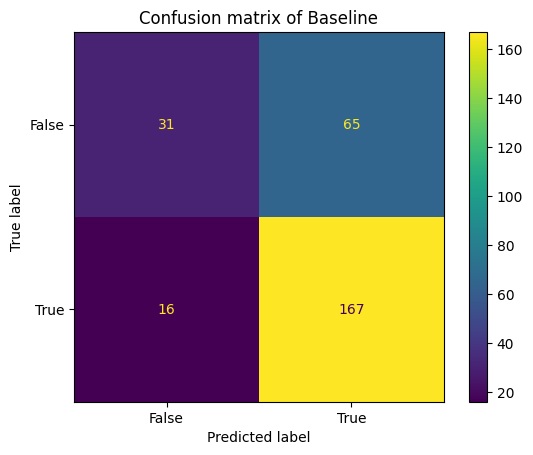

+-----------+-------------+
|  Metrics  | Results [%] |
+-----------+-------------+
|  ACCURACY |     71.0    |
| PRECISION |     72.0    |
|   RECALL  |     91.3    |
|    F_1    |     80.5    |
|   F_beta  |     90.9    |
+-----------+-------------+


In [25]:
groundtruth_vs_prediction_notna = groundtruth_vs_prediction.dropna()
num_tl_lane_pairs = groundtruth_vs_prediction_notna.shape[0]

visualize_confusion_matrix(groundtruth_vs_prediction_notna["relation"], groundtruth_vs_prediction_notna["predicted_relation"], "Confusion matrix of Baseline")
visualize_metrics(groundtruth_vs_prediction_notna["relation"], groundtruth_vs_prediction_notna["predicted_relation"], "Metrics of Baseline")

### Prior

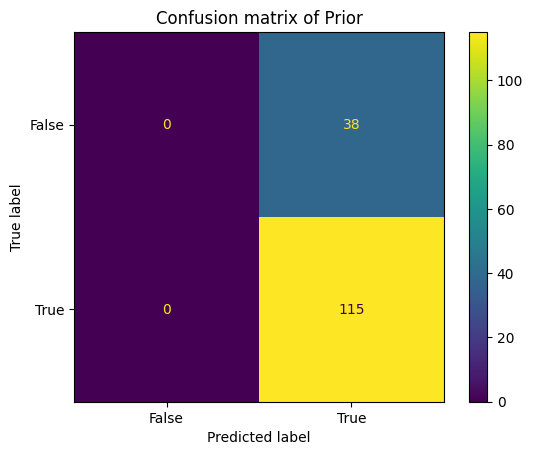

+-----------+-------------+
|  Metrics  | Results [%] |
+-----------+-------------+
|  ACCURACY |     75.2    |
| PRECISION |     75.2    |
|   RECALL  |    100.0    |
|    F_1    |     85.8    |
|   F_beta  |     99.5    |
+-----------+-------------+


In [15]:
groundtruth_vs_prediction_prior = groundtruth_vs_prediction_notna.copy()
groundtruth_vs_prediction_prior["predicted_relation"] = 1
visualize_confusion_matrix(groundtruth_vs_prediction_prior["relation"], groundtruth_vs_prediction_prior["predicted_relation"], "Confusion matrix of Prior")
visualize_metrics(groundtruth_vs_prediction_prior["relation"], groundtruth_vs_prediction_prior["predicted_relation"], "Metrics of Prior")


### Summary

In [16]:
summary = f"Number of scenes: {num_scenes}\n" + \
          f"Number of agents: {num_agents}\n" + \
          f"Number of tl-lane pairs: {num_tl_lane_pairs}"

print(summary)

Number of scenes: 70338
Number of agents: 70338
Number of tl-lane pairs: 153


### Show Prediction Differences
To identify and imporve the classifier it can be helpful to analyze which labels have been predicted incorrectly.

In [ ]:
diff = groundtruth_vs_prediction_notna.query("relation != predicted_relation").sort_values(by=["junction_id", "branch_id"])
diff

,tl_id,lane_id,relation,junction_id,branch_id,corrected,sequence_head_lane_id,scene_relation,avg_scene_relation,predicted_relation
17,3WL8,vLqW,0,3Ccg,S8XK4,0,vLqW,403,321,1
20,FlE6,vLqW,0,3Ccg,S8XK4,0,vLqW,321,321,1
24,aHR8,QLqW,0,3Ccg,S8XK4,0,QLqW,420,345,1
25,aHR8,vijX,0,3Ccg,S8XK4,0,vijX,103,70,1
27,umZo,QLqW,1,3Ccg,S8XK4,0,QLqW,127,345,0
...,...,...,...,...,...,...,...,...,...,...
179,APRT,5EUz,0,qnJy,NQxfR,0,5EUz,92,113,1
6,LL1i,AxmM,1,y4Ss,Evy5c,1,AxmM,128,372,0
7,LL1i,fxmM,1,y4Ss,Evy5c,1,fxmM,69,218,0
8,LL1i,+xmM,1,y4Ss,Evy5c,0,+xmM,124,384,0


### Compare to Rejection Method

In [22]:
if only_ego:
    rejection_method_prediction = pd.read_pickle("dataset/results/conservative/prediction_ego_only.pkl")
    print("Loaded prediction results for ego only")
else:
    rejection_method_prediction = pd.read_pickle("dataset/results/conservative/prediction_all_agents.pkl")
    print("Loaded prediction results for all agents")

Loaded prediction results for ego only


In [23]:
select_indices = rejection_method_prediction.set_index(["tl_id", "lane_id"]).index
print("Length of indices: ", len(select_indices))

Length of indices:  55


#### Select TL-Lane Pairs of Rejection Method

In [19]:
groundtruth_vs_prediction_notna = groundtruth_vs_prediction.dropna()
groundtruth_vs_prediction_notna = groundtruth_vs_prediction_notna.set_index(["tl_id", "lane_id"]).loc[select_indices].reset_index()

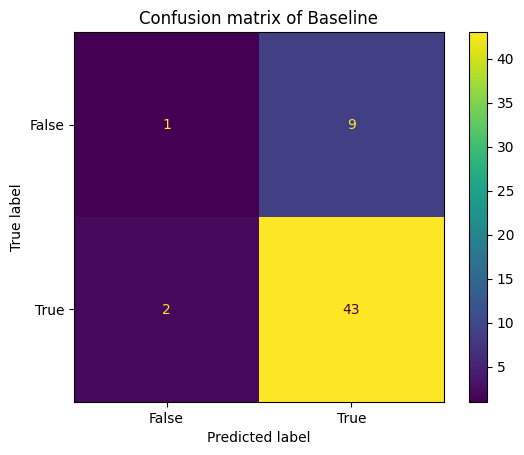

+-----------+-------------+
|  Metrics  | Results [%] |
+-----------+-------------+
|  ACCURACY |     80.0    |
| PRECISION |     82.7    |
|   RECALL  |     95.6    |
|    F_1    |     88.7    |
|   F_beta  |     95.3    |
+-----------+-------------+


In [20]:
num_tl_lane_pairs = groundtruth_vs_prediction_notna.shape[0]
visualize_confusion_matrix(groundtruth_vs_prediction_notna["relation"], groundtruth_vs_prediction_notna["predicted_relation"], "Confusion matrix of Baseline")
visualize_metrics(groundtruth_vs_prediction_notna["relation"], groundtruth_vs_prediction_notna["predicted_relation"], "Metrics of Baseline")

### Prior

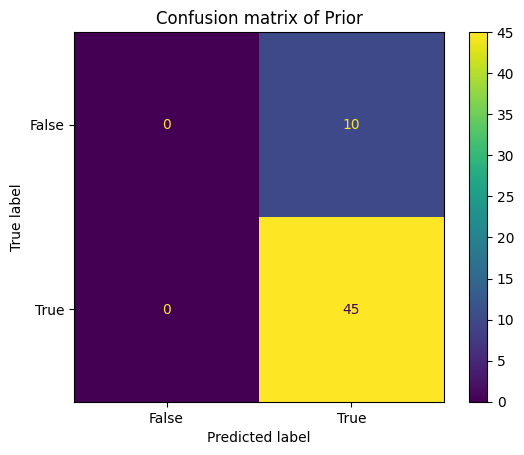

+-----------+-------------+
|  Metrics  | Results [%] |
+-----------+-------------+
|  ACCURACY |     81.8    |
| PRECISION |     81.8    |
|   RECALL  |    100.0    |
|    F_1    |     90.0    |
|   F_beta  |     99.7    |
+-----------+-------------+


In [22]:
groundtruth_vs_prediction_prior = groundtruth_vs_prediction_notna.copy()
groundtruth_vs_prediction_prior["predicted_relation"] = 1
visualize_confusion_matrix(groundtruth_vs_prediction_prior["relation"], groundtruth_vs_prediction_prior["predicted_relation"], "Confusion matrix of Prior")
visualize_metrics(groundtruth_vs_prediction_prior["relation"], groundtruth_vs_prediction_prior["predicted_relation"], "Metrics of Prior")

In [21]:
print("Number of traffic light-lane pairs:", num_tl_lane_pairs)

Number of l-lane pairs: 55


In [3]:

scene_tl_state = junctionDataset.get_scene_tl_state()
scene_tl_state.nunique()
print("Number of Traffic light Scenes:", scene_tl_state.nunique()["scene_idx"])

Number of Traffic light Scenes: 109068
